<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Deep-Deterministic-Policy-Gradients-(DDPG)" data-toc-modified-id="Deep-Deterministic-Policy-Gradients-(DDPG)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Deep Deterministic Policy Gradients (DDPG)</a></span><ul class="toc-item"><li><span><a href="#Import-the-Necessary-Packages" data-toc-modified-id="Import-the-Necessary-Packages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import the Necessary Packages</a></span></li><li><span><a href="#Instantiate-the-Environment-and-Agent" data-toc-modified-id="Instantiate-the-Environment-and-Agent-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Instantiate the Environment and Agent</a></span><ul class="toc-item"><li><span><a href="#Examine-the-state-and-action-spaces" data-toc-modified-id="Examine-the-state-and-action-spaces-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Examine the state and action spaces</a></span></li></ul></li><li><span><a href="#Train-the-Agent-with-DDPG" data-toc-modified-id="Train-the-Agent-with-DDPG-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Train the Agent with DDPG</a></span><ul class="toc-item"><li><span><a href="#4.-Watch-a-Smart-Agent!" data-toc-modified-id="4.-Watch-a-Smart-Agent!-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>4. Watch a Smart Agent!</a></span></li><li><span><a href="#5.-Explore" data-toc-modified-id="5.-Explore-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>5. Explore</a></span></li></ul></li></ul></li></ul></div>

# Deep Deterministic Policy Gradients (DDPG)
---
In this notebook, we train DDPG with OpenAI Gym's BipedalWalker-v2 environment.

## Import the Necessary Packages

In [1]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import importlib

import ddpg_agent
import prioritized_ddpg_agent

importlib.reload(prioritized_ddpg_agent)

<module 'prioritized_ddpg_agent' from 'C:\\Users\\thoma\\Documents\\GitHub\\deep-reinforcement-learning\\p3_collab-compet\\prioritized_ddpg_agent.py'>

## Instantiate the Environment and Agent

In [2]:
env = UnityEnvironment(file_name='Tennis_Windows_x86_64/Tennis.exe')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Creating functions for common environment processes

In [3]:
def environment_step(env, action, brain_name):
    env_info = env.step(action)[brain_name]
    next_states = env_info.vector_observations   # get the next state
    rewards = env_info.rewards                   # get the reward
    dones = env_info.local_done 
    
    return next_states, rewards, dones, None

def environment_reset(env, brain_name, train_mode=True):
    env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
    
    return env_info

### Examine the state and action spaces

In [4]:
# reset the environment
env_info = environment_reset(env, brain_name)

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Train the Agent with DDPG

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

In [52]:
import prioritized_ddpg_agent
importlib.reload(prioritized_ddpg_agent)
importlib.reload(ddpg_agent)

#agent = prioritized_ddpg_agent.PrioritizedAgent(state_size=state_size, action_size=action_size, random_seed=42)
#agent = ddpg_agent.Agent(
#    per_agent_state_size = state_size, 
#    per_agent_action_size = action_size, 
#    full_state_size = num_agents * state_size,
#    full_action_size = num_agents * action_size,
#    num_agents = num_agents,
#    random_seed=42)

agent = ddpg_agent.MADDPG(
    state_size,
    action_size,
    num_agents,
    random_seed=42
)
agent.act(states,0, add_noise=True)

array([[ 0.33537695, -0.21658804],
       [-0.7896132 ,  0.16463876]], dtype=float32)

In [53]:
import time

In [54]:
def ddpg(n_episodes=10000, max_t=int(1e6), solved_score=0.5, consec_episodes=100, print_every=1, train_mode=True,
         actor_path='actor_ckpt.pth', critic_path='critic_ckpt.pth'):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode
        solved_score (float)  : min avg score over consecutive episodes
        consec_episodes (int) : number of consecutive episodes used to calculate score
        print_every (int)     : interval to display results
        actor_path (str)      : directory to store actor network weights
        critic_path (str)     : directory to store critic network weights

    """
    mean_scores = []                               # list of mean scores from each episode
    min_scores = []                                # list of lowest scores from each episode
    max_scores = []                                # list of highest scores from each episode
    best_score = -np.inf
    scores_window = deque(maxlen=consec_episodes)  # mean scores from most recent episodes
    moving_avgs = []                               # list of moving averages
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            
            actions = agent.act(states, i_episode, add_noise=True)         # select an action
            next_states, rewards, dones, _ = environment_step(env, actions, brain_name)
            
            # save experience to replay buffer & perform learning step if current timesteps allows it
            #for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            agent.step(states, actions, rewards, next_states, dones, i_episode)             
            states = next_states
            scores += rewards
                        
            if np.any(dones):                                   # exit loop when episode ends
                break

        duration = time.time() - start_time
        min_scores.append(np.min(scores))             # save lowest score
        max_scores.append(np.max(scores))             # save highest score    
        mean_scores.append(np.mean(scores))           # save mean score for the episode
        scores_window.append(mean_scores[-1])         # save mean score to deque
        moving_avgs.append(np.mean(scores_window))    # save moving average from the 100 sized deque
                
        if i_episode % print_every == 0:
            print('\rEpisode {} ({} sec)  -- \tMin: {:.2f}\tMax: {:.2f}\tMean: {:.2f}\tMov. Avg: {:.2f}'.format(\
                  i_episode, round(duration), min_scores[-1], max_scores[-1], mean_scores[-1], moving_avgs[-1]))
                  
        if moving_avgs[-1] >= solved_score and i_episode >= consec_episodes:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.2f} over last {} episodes'.format(\
                                    i_episode-consec_episodes, moving_avgs[-1], consec_episodes))            
            if train_mode:
                agent.save_maddpg()
            break
            
    return mean_scores, moving_avgs

In [ ]:
scores, avgs = ddpg()

Episode 1 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: -0.00
Episode 2 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: -0.00
Episode 3 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: -0.00
Episode 4 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: -0.00
Episode 5 (0 sec)  -- 	Min: -0.01	Max: 0.10	Mean: 0.05	Mov. Avg: 0.01
Episode 6 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.00
Episode 7 (0 sec)  -- 	Min: 0.00	Max: 0.09	Mean: 0.05	Mov. Avg: 0.01
Episode 8 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 9 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 10 (0 sec)  -- 	Min: -0.01	Max: 0.10	Mean: 0.05	Mov. Avg: 0.01
Episode 11 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 12 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 13 (0 sec)  -- 	Min: -0.01	Max: 0.10	Mean: 0.05	Mov. Avg: 0.01
Episode 14 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Ep

Episode 115 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 116 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 117 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 118 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 119 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 120 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 121 (0 sec)  -- 	Min: -0.01	Max: 0.10	Mean: 0.05	Mov. Avg: 0.01
Episode 122 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 123 (0 sec)  -- 	Min: -0.01	Max: 0.10	Mean: 0.05	Mov. Avg: 0.01
Episode 124 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 125 (0 sec)  -- 	Min: 0.00	Max: 0.09	Mean: 0.05	Mov. Avg: 0.01
Episode 126 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 127 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 128 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.

Episode 229 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 230 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 231 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 232 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 233 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 234 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 235 (0 sec)  -- 	Min: 0.09	Max: 0.10	Mean: 0.10	Mov. Avg: 0.01
Episode 236 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 237 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 238 (0 sec)  -- 	Min: -0.01	Max: 0.10	Mean: 0.05	Mov. Avg: 0.01
Episode 239 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 240 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 241 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 242 (0 sec)  -- 	Min: -0.02	Max: 0.00	Mean: -0

Episode 342 (4 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.00
Episode 343 (4 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.00
Episode 344 (4 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.00
Episode 345 (4 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.00
Episode 346 (3 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.00
Episode 347 (3 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.00
Episode 348 (4 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.00
Episode 349 (4 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.00
Episode 350 (4 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.00
Episode 351 (3 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.00
Episode 352 (4 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.00
Episode 353 (4 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.00
Episode 354 (4 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: -0.00
Episode 355 (3 sec)  -- 	Min: -0.01	Max: 0.00	Mean

Episode 456 (9 sec)  -- 	Min: 0.09	Max: 0.10	Mean: 0.10	Mov. Avg: 0.03
Episode 457 (13 sec)  -- 	Min: 0.09	Max: 0.10	Mean: 0.10	Mov. Avg: 0.03
Episode 458 (4 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.03
Episode 459 (8 sec)  -- 	Min: -0.01	Max: 0.10	Mean: 0.05	Mov. Avg: 0.03
Episode 460 (8 sec)  -- 	Min: -0.01	Max: 0.10	Mean: 0.05	Mov. Avg: 0.03
Episode 461 (8 sec)  -- 	Min: -0.01	Max: 0.10	Mean: 0.05	Mov. Avg: 0.04
Episode 462 (9 sec)  -- 	Min: -0.01	Max: 0.10	Mean: 0.05	Mov. Avg: 0.04
Episode 463 (8 sec)  -- 	Min: -0.01	Max: 0.10	Mean: 0.05	Mov. Avg: 0.04
Episode 464 (4 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.04
Episode 465 (10 sec)  -- 	Min: -0.01	Max: 0.10	Mean: 0.05	Mov. Avg: 0.04
Episode 466 (4 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.04
Episode 467 (19 sec)  -- 	Min: 0.09	Max: 0.20	Mean: 0.15	Mov. Avg: 0.04
Episode 468 (8 sec)  -- 	Min: 0.00	Max: 0.09	Mean: 0.05	Mov. Avg: 0.04
Episode 469 (25 sec)  -- 	Min: 0.19	Max: 0.20	Mean: 0.20	Mov. 

Episode 570 (31 sec)  -- 	Min: 0.19	Max: 0.30	Mean: 0.25	Mov. Avg: 0.08
Episode 571 (5 sec)  -- 	Min: 0.00	Max: 0.09	Mean: 0.05	Mov. Avg: 0.08
Episode 572 (4 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.08
Episode 573 (20 sec)  -- 	Min: 0.09	Max: 0.20	Mean: 0.15	Mov. Avg: 0.09
Episode 574 (34 sec)  -- 	Min: 0.29	Max: 0.30	Mean: 0.30	Mov. Avg: 0.09
Episode 575 (29 sec)  -- 	Min: 0.19	Max: 0.30	Mean: 0.25	Mov. Avg: 0.09
Episode 576 (14 sec)  -- 	Min: 0.09	Max: 0.10	Mean: 0.10	Mov. Avg: 0.09
Episode 577 (8 sec)  -- 	Min: -0.01	Max: 0.10	Mean: 0.05	Mov. Avg: 0.09
Episode 578 (4 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.09
Episode 579 (39 sec)  -- 	Min: 0.29	Max: 0.40	Mean: 0.35	Mov. Avg: 0.09
Episode 580 (18 sec)  -- 	Min: 0.09	Max: 0.20	Mean: 0.15	Mov. Avg: 0.09
Episode 581 (14 sec)  -- 	Min: 0.09	Max: 0.10	Mean: 0.10	Mov. Avg: 0.09
Episode 582 (49 sec)  -- 	Min: 0.39	Max: 0.50	Mean: 0.45	Mov. Avg: 0.10
Episode 583 (4 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. 

In [32]:
agent.epsilon

0.7459127835533744

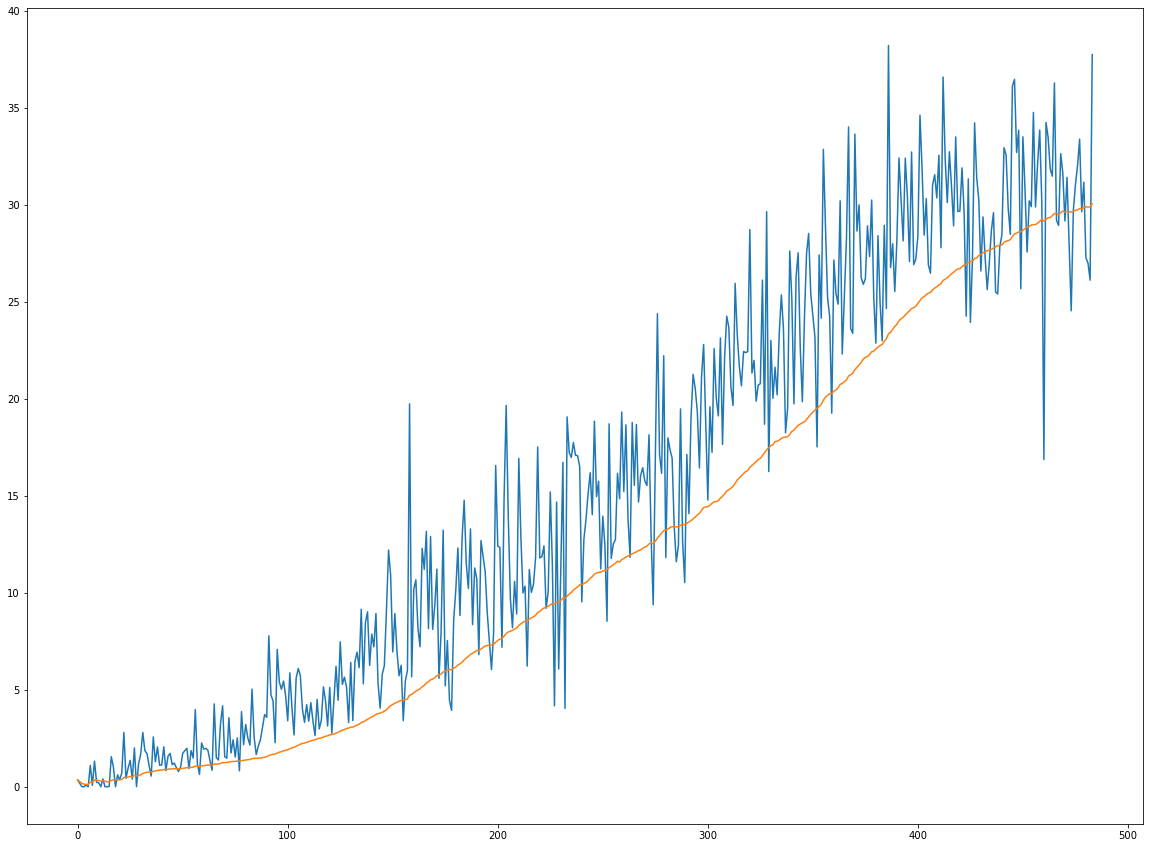

In [18]:
plt.figure(figsize=(20,15))
plt.plot(scores)
plt.plot(avgs)

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [20]:
agent.actor_local.load_state_dict(torch.load('actor_weights_simple_replay_buffer.pth'))
agent.critic_local.load_state_dict(torch.load('critic_weights_simple_replay_buffer.pth'))

state = env.reset()
agent.reset()   
while True:
    action = agent.act(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break
        


TypeError: expected np.ndarray (got dict)

In [78]:
env.close()

### 5. Explore

In this exercise, we have provided a sample DDPG agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster than this benchmark implementation.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task!
- Write your own DDPG implementation.  Use this code as reference only when needed -- try as much as you can to write your own algorithm from scratch.
- You may also like to implement prioritized experience replay, to see if it speeds learning.  
- The current implementation adds Ornsetein-Uhlenbeck noise to the action space.  However, it has [been shown](https://blog.openai.com/better-exploration-with-parameter-noise/) that adding noise to the parameters of the neural network policy can improve performance.  Make this change to the code, to verify it for yourself!
- Write a blog post explaining the intuition behind the DDPG algorithm and demonstrating how to use it to solve an RL environment of your choosing.  